In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Differentiating Through Randomness

In the previous notebook we covered the basics of automatic differentiation (AD). However, we focused on differentiating deterministic programs that always produce the same output given the same input. In contrast, ABMs are typically stochastic in nature. In this notebook we will explore how one can employ AD to differentiate through randomness.

## Fixed noise distributions

Consider the following stochastic model $f$ with input parameter $\theta$:

$$
\begin{align*}
    z &\sim \mathcal N(1, 2) \\
    y &= \theta^2(z+4)
\end{align*}
$$

Here, $\mathcal N(\mu, \sigma)$ denotes the Normal distribution with mean $\mu$ and standard deviation $\sigma^2$. We can implement this model via the following **stochastic program**:

In [3]:
def f(theta):
    z = np.random.normal(1, 2)
    return theta**2 * (z + 4)

We can now ask what it means to compute the derivative of $f$ with respect to $\theta$. Recall the standard definition of the derivative for scalar univariate functions:

$$
\frac{d f(\theta)}{d \theta} =  \lim_{\epsilon \to 0} \frac{f(\theta+\epsilon) - f(\theta)}{\epsilon}.
$$

Note that the difference $f(\theta+\epsilon) - f(\theta)$ is now a random quantity, and as a result it is unclear how we should treat the limit on the right-hand side. Significant research effort has been dedicated to the development of **sample derivatives** which address this issue. Whilst much of what we will discuss here can be framed in terms of sample derivatives, we will take a simpler approach and circumvent this theory for the time being.

In practice, we are typically interested in the **average** behaviour of a model, rather than the output associated with a single run. In the case of our example, this means we want to compute the following gradient:

$$ \nabla_{\theta}\mathbb{E}_{z \sim \mathcal{N}(1,2)}[\theta^{2}(z+4)]$$

This is a specific instance of the more general gradient estimation problem:

$$
\nabla_{\theta}\mathbb E_{p(z)} [f_\theta(z)]
$$

where $f_{\theta}$ is any function which is deterministic with respect to $z$ and differentiable with respect to $\theta$. Note that the noise distribution, as specified by the density $p$, does not depend on $\theta$. We will relax this assumption later on. Let's expand and rewrite this gradient slighty.

$$  \begin{align*}
    \nabla_{\theta}\mathbb E_{p(z)} [f_\theta(z)] &=
    \nabla_{\theta}\int p(z)f_\theta(z)dz \\
    &= \int p(z)\nabla_{\theta}f_{\theta}(z)dz \\
    &= \mathbb{E}_{z \sim p(z)}[\nabla_{\theta}f_{\theta}(z)].
    \end{align*}
$$

Put simply, we find that the gradient of the expectation is equal to the expectation of the gradient. In the second equality, we assumed that $f_{\theta}(x)$ is *sufficiently regular* so that Leibniz's rule applies. That is, we are allowed to exchange the integral and derivative operators. Almost all the functions used in machine learning satisfy this criteria. If you are curious about the technical details, I recommend checking out [this paper](https://www.jstor.org/stable/2319163), which investigates when the exchange of integration and differentiation is generally permitted.

We can now derive a closed-form expression for the gradient in our running example:

$$
\nabla_\theta \mathbb E_{z \sim \mathcal N(1, 2)}\;\left[\theta(z+4)\right] = \mathbb E_{z\sim \mathcal N(1,2)} \left[\nabla_\theta \theta^2(z+4)\right] = 10\, \theta
$$

We can check this is correct numerically by applying finite differences (FD) directly to the expectation. In this case, FD corresponds to the following approximation scheme:

$$ \nabla_{\theta}\mathbb E_{p(z)} [f_\theta(z)] \approx \frac{\mathbb{E}_{z \sim p(z)}[f_{\theta + \epsilon}(z)] - \mathbb{E}_{z \sim p(z)}[f_{\theta}(z)]}{\epsilon}$$

Generally speaking, we can't compute the expectations within this quotient, as this requires integrating over the support of $z$. However, we can unbiasedly estimate them using a standard Monte Carlo approximation:

$$ \nabla_{\theta}\mathbb E_{p(z)} [f_\theta(z)] \approx \frac{\frac{1}{m}\sum^{m}_{i=1}f_{\theta + \epsilon}(z_{i, 1}) - \frac{1}{m}\sum_{i=1}^{m}f_{\theta}(z_{i, 2})}{\epsilon}, $$

where $z_{i, 1} \sim p$ and $z_{i, 2} \sim p$. Let's plot a histogram of the gradients returned by the above FD estimator for different values of $\epsilon$!

<!-- However, in many cases, we are actually interested in the derivative of an **average** model realization, not just the derivative of a single run. In other words, we want to take gradients of the form

$$
\mathbb E_{z \sim \mathcal N(1, 2)}\;\left[\theta^2(z+4)\right]
$$

where $p$ is a probability density and $f$ is a (deterministic) simulator with structural parameters $\theta$. Taking the derivative we have

$$
\begin{align*}
    \nabla_\theta \mathbb E_{p(z)}\;\left[f_\theta(z)\right] &= \nabla_\theta\left[\int_z p(z) f_\theta(z)\mathrm{d}z\right]\\
                                                             &=  \int_z p(z)\left[\nabla_\theta f_\theta(z)\right]\mathrm{d} z \\
                                                             &= \mathbb E_{p(z)}[\nabla_\theta f_\theta(z)]
\end{align*}
$$ -->

<!-- so that the gradient of the expectation is the expectation of the gradient.

In our considered example, this translates to

$$
\mathbb E_{z \sim \mathcal N(1, 2)}\;\left[\theta^2(z+4)\right]
$$

now we can take the derivative

$$
\nabla_\theta \mathbb E_{z \sim \mathcal N(1, 2)}\;\left[\theta(z+4)\right] = \mathbb E_{z\sim \mathcal N(1,2)} \left[\nabla_\theta \theta^2(z+4)\right] = 10\, \theta
$$

Let's check this result numerically. -->

In [4]:
theta = 2.0
epsilons = [1.0, 0.5, 0.1]
n_samples = 10_000
samples_per_epsilon = {epsilon: [] for epsilon in epsilons}
for epsilon in epsilons:
    for i in range(n_samples):
        f_deriv = (f(theta + epsilon) - f(theta)) / (epsilon)
        samples_per_epsilon[epsilon].append(f_deriv)

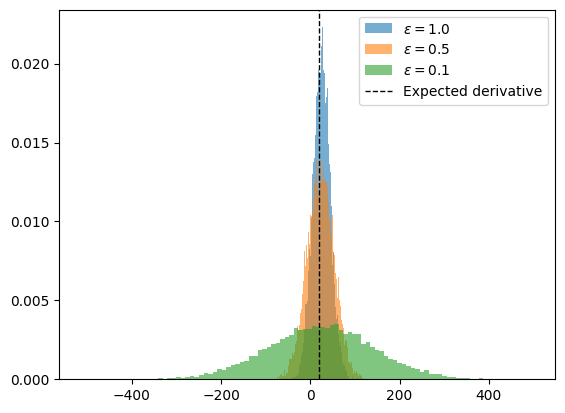

In [5]:
fig, ax = plt.subplots()
for i, (epsilon, samples) in enumerate(samples_per_epsilon.items()):
    ax.hist(
        samples,
        bins=100,
        alpha=0.6,
        label=f"$\epsilon={epsilon}$",
        density=True,
        color=f"C{i}",
    )
ax.axvline(
    theta * 10,
    color="black",
    linestyle="dashed",
    linewidth=1,
    label="Expected derivative",
)
ax.legend()

For all $\epsilon$ tested, the mean of our estimator roughly corresponds to the true analytical gradient derived above, which is represented by the vertical dashed line. We also notice another striking pheneomena. As $\epsilon \to 0$, the variance of our estimator increases. Why is this? 

Recall the Monte Carlo estimate we employed to approximate FD:

$$ \sum^{m}_{i=1}f_{\theta + \epsilon}(z_{i, 1}) - \sum_{i=1}^{m}f_{\theta}(z_{i, 2}) $$

This is the only random quantity and hence the source of all the variance. When we divide through by $\epsilon$ this term is scaled up, dramatically increasing its variance. The smaller the $\epsilon$, the worse this effect will be. As we saw in the last notebook, sometimes we need set $\epsilon$ to a small value to get a good approximation of the gradient. As a result, we can't rely on increasing $\epsilon$ as a strategy to reduce variance. Our only option is to reduce the initial variance of the Monte Carlo term above. 

The simplest way to reduce variance is increasing the number of samples $m$ used in each Monte-Carlo approximation. However, this involves more function evaluations, which in turn may be computationally expensive, especially if $f$ is an ABM. Alternatively, one can reduce variance by coupling the noise terms used in each Monte Carlo sum. That is, setting $z_{i, 1} = z_{i, 2}$. This reduces noise introduced by evaluating $f$ at different sample points when taking the difference between sums. However, syncrhonising the noise terms in practice can be difficult, and is not as simple as fixing a random seed!

Next, let's consider the following approximation of the derivative:

$$ \frac{1}{m}\sum^{m}_{i=1}\nabla_{\theta}f_{\theta}(z_{i}), $$

where each gradient term is computed using AD instead of FD. Note that we no longer need to take a difference of terms, nor do we need to divide by a small value. As a result, we should expect the variance of this estimator to be far lower. Let's plot its corresponding histogram and check!

<!-- What is going on? The smaller $\epsilon$ is, the variance of our estimator is going $\to \infty$! 

This is caused by the fact that the two function calls $X(p)$ and $X(p+\epsilon)$ are uncorrelated (they have a different random seed) and so even calling the program for very similar values of $p$ can cause large differences. 

Nonetheless, the finite differences method gives an unbiased estimator.

This issue is not present in automatic differentiation engines, since they only require one evaluation of the model. -->

In [6]:
def f_torch(theta):
    z = torch.distributions.Normal(1.0, 2.0).sample()
    return theta**2 * (z + 4)


n_samples = 10_000
samples_autograd = []
for i in range(n_samples):
    theta = torch.tensor(2.0, requires_grad=True)
    f_torch(theta).backward()
    samples_autograd.append(theta.grad)

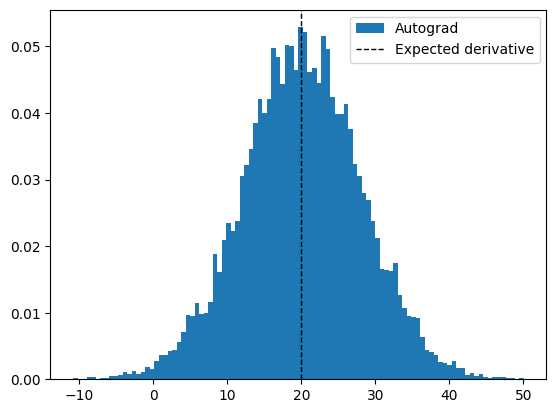

In [7]:
fig, ax = plt.subplots()
ax.hist(
    samples_autograd, bins=100, label="Autograd", density=True, color="C0"
)
ax.axvline(
    10*theta.item(), color="black", linestyle="dashed", linewidth=1, label="Expected derivative"
)
ax.legend()

As we can see, using AD leads to much lower variance compared to using FD!

## Parameterizable Noise

So far, we have assumed that the randomness of our model, described by $p(z)$, did not depend on the structural parameters $\theta$ that we want to differentiate with respect to. However, in most ABMs this assumption does not hold. For instance, consider an epdiemlogical model where agents become infected with some probability. This probability may depend on structural parameters representing factors that we are interested in calibrating, such as disease contagiousness or social distancing measures.

In such cases, we need to estimate the following gradient:

$$
\nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)],
$$

where $p$ is parameterized by $\theta$. Let's expand this gradient just like we did in the previous section.

$$
\begin{align*}
    \nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)] &= \nabla_\theta \left[ \int_z p_\theta(z) f_\theta(z) \mathrm{d}z\right]\\
                                                       &= \int_z \nabla_\theta\left[p_\theta(z) f_\theta(z)\right] \mathrm{d}z\\
                                                       &= \int_z f_\theta(z)\nabla_\theta p_\theta(z)\mathrm{d} z + \int_z p_\theta(z) \nabla_\theta f_\theta(z)\mathrm{d}z\\
                                                       &= \int_z f_\theta(z) \nabla_\theta p_\theta(z) \mathrm{d} z + \mathbb E_{p_\theta(z)} \left[\nabla_\theta f_\theta(z)\right]
\end{align*}
$$

Notice that we now have an additional term, $\int_z f_\theta(z) \nabla_\theta p_\theta(z) \mathrm{d} z$, that prevents us from commuting the gradient and the expectation. Hence, in general, **the gradient of the expectation is not the expectation of the gradient** when our structural parameters parameterize the randomness. In the next subsection, we will introduce a trick for estimating the gradient when $p$ is continuous.


### The Reparameterization Trick

 <!-- To circumvent this, we introduce the [reparameterization trick](https://arxiv.org/pdf/1312.6114.pdf).  -->
 
 <!-- For now, we assume that $p$ describes a continuous.  -->
 
 <!-- Continuous distributions have a property that allows an indirect way of sampling from them. One is direct sampling -->

 Roughly speaking, there are two basic ways to sample from a continuous distribution $p_{\theta}$. We may sample directly from $p_{\theta}$:

$$ x \sim p_\theta(x), $$

or we can sample auxillary noise $\varepsilon$ from another distribution $q$, and apply a deterministic transform $g_{\theta}$ so that the resulting output is distributed according to $p_{\theta}$. This is broadly known as indirect sampling,

$$  x = g_{\theta}(\varepsilon), \quad \varepsilon \sim q(\varepsilon) $$

<!-- where $g$ is a deterministic path that maps parameter-free noise ($\epsilon$) to $x$.  -->

When $q$ is the standard uniform density, this procedure corresponds to inverse transform sampling, and $g$ corresponds to the inverse CDF function associated with $p_{\theta}$.  However, sometimes there are better choices for $q$ that make $g_{\theta}$ easier to compute. For instance, to sample from the normal distribution $\mathcal N(\mu, \sigma^2)$, we can use the standard normal distribution $\mathcal{N}(0, 1)$ to sample auxillary noise:

$$ \varepsilon \sim \mathcal N(0, 1), \quad x  =  \mu + \sigma \varepsilon $$


So why do we care about indirect sampling? Since indirect and direct sampling produce the same distribution we clearly have:

$$
\mathbb{E}_{p_{\theta}(z)}[f_{\theta}(z)] = \mathbb{E}_{\varepsilon \sim q(\varepsilon)}[f_{\theta}(g_{\theta}(\varepsilon))].
$$

Thus, taking gradients we have
$$
\nabla_{\theta}\mathbb{E}_{p_{\theta}(z)}[f_{\theta}(z)] = \nabla_{\theta}\mathbb{E}_{\varepsilon \sim q(\varepsilon)}[f_{\theta}(g_{\theta}(\varepsilon))] 
$$

Note that the sampling distribution $q(\varepsilon)$ does not depend on $\theta$. Thus, if $g_{\theta}$ and $f_{\theta}$ are both differentiable and sufficiently regular, we can exchange the gradient and expectation operators on the right-hand side, just as we had done in the previous section!

$$
\nabla_{\theta}\mathbb{E}_{p_{\theta}(z)}[f_{\theta}(z)] = \mathbb{E}_{\varepsilon \sim q(\varepsilon)}[\nabla_{\theta}f_{\theta}(g_{\theta}(\varepsilon))] 
$$

Proceeding as before, we can now construct an AD-based Monte Carlo estimator for the gradient of interest:

$$
\nabla_{\theta}\mathbb{E}_{p_{\theta}(z)}[f_{\theta}(z)] \approx \frac{1}{m}\sum^{m}_{i=1}\nabla_{\theta}f_{\theta}(g_{\theta}(\varepsilon_{i})), \quad \varepsilon_{i} \sim q
$$

This method of gradient computation is known as the [reparameterization trick](https://arxiv.org/pdf/1312.6114.pdf) within the machine learning community, and was originally exploited to train VAEs. Indirect sampling effectively *reparameterizes* the noise variable $z$ so that it not longer depends on the structural parameters $\theta$.

Let's study an example. Consider the following model:

$$
\begin{align*}
z \sim \mathcal N(\theta, 4) \\
y = \theta^2 (4 + z)
\end{align*}
$$

We can reparameterize the noise variable $z$ using the standard normal distribution:

$$
\begin{align*}
\varepsilon \sim \mathcal{N}(0, 1) \\
y = \theta^2 (4 + \theta + 2\varepsilon)
\end{align*}
$$

We can now compute the gradient:

$$
\mathbb E_{\epsilon \sim \mathcal N(0,1)}\left[ \nabla_\theta \theta^2 (4 + \theta + 2\epsilon )\right ] =\mathbb E_{\epsilon \sim \mathcal N(0,1)}[8\theta + 3\theta^2 + 4\theta\epsilon] = 8\theta + 3\theta^2
$$

<!-- What have we accomplished with this? We have untangled the "random" part of the distribution from the part that depends on the parameters.
This allows us to re-formulate (1) as

$$
\nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)] = \nabla_\theta\mathbb E_{p(\varepsilon)}\left[f(g_\theta(\varepsilon, x))\right],
$$

where now we can move the gradient inside,

$$
\nabla_\theta\mathbb E_{p(\epsilon)}\left[f(g_\theta(\epsilon, x))\right] = \mathbb E_{p(\varepsilon)}\left[\nabla_\theta f(g_\theta(\varepsilon, x))\right].
$$

So we have been able to transform the gradient of the expectation to the expectation of the gradient. This can be computed provided that $f$ and $g$ are differentiable. This expectation can now be estiated by Monte Carlo,

$$
\mathbb E_{p(\epsilon)}\left[\nabla_\theta f(g_\theta(\epsilon, x))\right] \approx \frac{1}{N} \sum_{i=1}^N \nabla_\theta f(g_\theta(\epsilon_i, x_i)).
$$ -->

<!-- Let's see an example. Consider the program with input $\theta$

$$
\begin{align*}
z \sim \mathcal N(\theta, 4) \\
y = \theta^2 (4 + z)
\end{align*}
$$

The expected answer is

$$
\mathbb E_{\epsilon \sim \mathcal N(0,1)}\left[ \nabla_\theta \theta^2 (4 + \theta + 2\epsilon )\right ] =\mathbb E_{\epsilon \sim \mathcal N(0,1)}[8\theta + 3\theta^2 + 4\theta\epsilon] = 8\theta + 3\theta^2
$$

Let's first check both the parameterized and unreparameterized version: -->

Let's now explore how the reparameterization trick is implemented in PyTorch. Below, we define two stochatsic programs. The program `f_torch_norep` implements the previous example without performing any explicit reparameterization by sampling $z$ directly from `torch.distributions.Normal(theta, 2.0)`. The program `f_torch` explicitly reparameterizes by first sampling from `torch.distributions.Normal(0,1)` and then constructing `z`. Let's plot the density of these two estimators.

In [8]:
def f_torch_norep(theta):
    z = torch.distributions.Normal(theta, 2.0).sample()
    return theta**2 * (z + 4)


def f_torch(theta):
    epsilon = torch.distributions.Normal(0, 1).sample()
    z = theta + epsilon * 2
    return theta**2 * (4 + z)


rep_samples = []
norep_samples = []
n_samples = 2_000
theta_value = 2.0
analytical_result = 8 * theta_value + 3 * theta_value**2
for i in range(n_samples):
    theta = torch.tensor(theta_value, requires_grad=True)
    f_torch_norep(theta).backward()
    norep_samples.append(theta.grad.item())
    theta = torch.tensor(theta_value, requires_grad=True)
    f_torch(theta).backward()
    rep_samples.append(theta.grad.item())

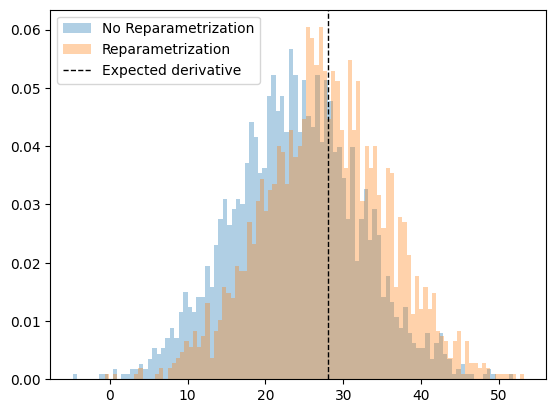

In [9]:
fig, ax = plt.subplots()
ax.hist(
    norep_samples,
    bins=100,
    alpha=0.35,
    label="No Reparametrization",
    density=True,
    color="C0",
)
ax.hist(
    rep_samples,
    bins=100,
    alpha=0.35,
    label="Reparametrization",
    density=True,
    color="C1",
)
ax.axvline(
    analytical_result,
    color="black",
    linestyle="dashed",
    linewidth=1,
    label="Expected derivative",
)
ax.legend()

As we can see, `f_torch` is an unbiased estimator of the analytical gradient as it explicitly employs the reparameterization trick. In contrast,`f_torch_norep` is biased. This is because `.sample()` does not implicitly perform the reparamterization trick. Instead, gradient propoagation stops at `.sample()`. Thankfully, PyTorch implements the shortcut function `.rsample` which implicitly performs the reparameterization trick for us so we do not need to implement it over and over again. Below we perform the reparameterization trick for our example implicitly via `.rsample`. Observe that an accurate estimate for the analytical gradient is returned.

<!-- As we can see, we need to be careful, because PyTorch may not be applying the reparameterization trick and we may obtain the wrong results!!

By calling `dist.sample()` the gradient propagation stops and so we obtain the wrong result. Thankfully, PyTorch has a shortcut to implement the reparameterization trick for us so we don't have to do it manually. This can be done by using the `.rsample()` method. -->

In [10]:
def f_torch(theta):
    z = torch.distributions.Normal(theta, 2.0).rsample()
    return theta**2 * (z + 4)


rep = (
    sum([torch.func.grad(f_torch)(torch.tensor(2.0)) for i in range(n_samples)])
    / n_samples
)
print(f"{rep} ~ {analytical_result}")

27.927927017211914 ~ 28.0


<!-- # A note on reinforcement learning

Recall equation (1):

$$
\nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)].
$$

There is an alternative way to re-express this gradient:

$$
\begin{split}
\nabla_\theta\mathbb E_{p_\theta(z)} [f_\theta(z)] &= \nabla_\theta \int p_\theta(z) f_\theta(z) \mathrm{d} z \\
&= \int f(z) \nabla_\theta p(z) \mathrm{d}z \\
&= \int p_\theta(z) f_\theta(z) \nabla_\theta \log p_\theta(z) \mathrm{d} z \\
&= \mathbb E_{p_\theta(z)}\left[f(z) \nabla_\theta \log p_\theta(z)\right]
\end{split}
$$

The familiar reader will recognize the last expression as the score-based estimator of the gradient, also known as REINFORCE in the RL community.
The advantage of calculating the gradient this way, is that we only require the density $p$ to be differentiable, but we have no constraints on $f$. However, this gradient does not scale well for high dimensionality of $\theta$, compared to the path-wise approach, since the variance scales with the dimension of $\theta$. See [this reference](https://arxiv.org/abs/1906.10652) for an in-depth review. -->

## Discrete Randomness

The reparameterization trick assumes that a probability density can be reparameterised effectively with a smooth transform. This assumption holds for most of the continuous distributions we encounter in machine learning. Unfortunately, this assumption does not hold for Bernoulli and categorical distributions, which are frequently used in ABM implementations, since they are discrete. To differentiate through discrete distributions, we need to seek an alternative to the reparamterization trick.

<!-- This is true for continuous distributions but it does not hold for discrete ones such as Bernoulli or Categorical distributions. -->

Multiple methods have been proposed aiming to address this gap. These include surrogate gradient methods, such as the straight-through gradient estimator [(Bengio et al. 2013)](https://arxiv.org/abs/1308.3432), which replace discrete sample operations with a smooth approximation when applying the chain rule. More recent approaches include the Julia package [StochasticAD.jl](https://arxiv.org/abs/2210.08572), which leverages the theory of sample derivatives to efficiently compute unbiased pathwise gradient estimators. Unfortunately, we do not have time to cover all of these methods in detail. Instead will focus on one prominent method: the **Gumbel-Softmax (GS) trick** [(Jang et al. 2016)](https://arxiv.org/abs/1611.01144).

One way to circumvent differentiability issues with a discrete distribution is to replace it with a continuous distribution that can be reparameterized. Of course, we should choose a continuous distribution that approximates the original distribution well so that gradients are informative. Consider the categorical distribution of $n$ categories with parameters $\pi =(\pi_{1}, \dots, \pi_{n})$. Here, $\pi_{i}$ indicates the probability that category $i$ is sampled. How might we construct an appropriate continuous distribution in this case?

It turns out that the categorical distribution is closely related to the Gumbel distribution. By exploiting the structure of the Gumbel distribution and basic properties of order statistics one can show that:

$$ \arg\max_{i}(g_{i} + \log\pi_{i}) \sim \text{Cat}(\pi), \quad g_{i} \sim \text{Gumbel}(0)$$

 That is, we can reparameterize the categorical distribution using the Gumbel distribution. See [this paper](https://arxiv.org/abs/1411.0030) for the technical details. Unsurprisingly, this is known as the Gumbel-max trick. Unfortunately, this reparameterization is not differentiable as the $\arg\max$ function is not differentiable. To rectify this we can replace $\arg\max$ with a $\text{softmax}$ operator, obtaining the Gumbel-Softmax distribution. 
$$ y_{i} = \frac{\exp((\log\pi_{i} + g_{i})/\tau)}{\sum_{j=1}^{n}\exp((\log\pi_{j} + g_{j})/\tau)}  \quad g_{i} \sim \text{Gumbel}(0)$$

Note that, when we apply the $\text{softmax}$ operator, we also include a temperature parameter $\tau > 0$. As we decrease $\tau$, the GS distribution forms a better approximation of $\text{Cat}(\pi)$. In fact, one can show that as $\tau \to 0$, the GS distribution converges to $\text{Cat}(\pi)$. Unfortunately, the variance of gradient estimates increase rapidly as $\tau \to 0$. This is reminiscent of our experience with FD, where dividing by small values caused high variance. As a result, we face a **bias-variance trade-off** when setting $\tau$.


<!-- Multiple methods exist to deal with this issue, the most common ones being the Straight-Through estimator [(Bengio et al. 2013)](https://arxiv.org/abs/1308.3432) or the Gumbel-Softmax trick [(Jang et al. 2016)](https://arxiv.org/abs/1611.01144). Newer methods are continuously being developed such as the [StochasticAD.jl](https://arxiv.org/abs/2210.08572) package in the Julia language. -->

<!-- Here, we focus on the Gumbel-Softmax (GS) trick.  -->

<!-- The GS distribution is a continuous relaxation of the categorical distribution. The GS has a temperature parameter $\tau$ which controls the smoothness of the approximation such that the exact Categorical sampling is recovered for $\tau\to 0$. However, the variance of the gradient will grow as $\tau\to 0$ so $\tau$ acts as a bias-variance trade-off. -->

PyTorch has a standard implementation of the GS estimator built in. In particular, PyTorch implements a *hard* version of the GS trick, which uses samples from $\text{Cat}(\pi)$ when performing the forward pass, but uses samples from the GS distribution during the backwards pass. By doing this, PyTorch guarantees that evaluations of the stochastic program are unaltered, whilst gradients can still be computed. In other words, GS samples are used as **surrogates** for categorical samples during the backwards pass in reverse-mode AD. This is particularly useful for ABMs which often use operations defined only on discrete values. With that being said, let's experiment with the GS trick in PyTorch!

<!-- In particular, it implements a "hard" version of GS. The idea is that we can use the samples from the categorical distribution in the forward simulated pass, and use the continuous relaxation to approximate the gradients in the backward pass. This way we guarantee that the forward simulation is exactly equivalent to the non-relaxed version. -->

Consider the following program:

$$
x = 2 \mathrm{Bern}(3\theta) + \mathrm{Bern}(\theta),
$$

where $\text{Bern}$ denotes the Bernoulli distribution. We can easily compute the gradient of the expectation in this case:

$$
\nabla_\theta \mathbb E [2 \mathrm{Bernoulli}(3\theta) + \mathrm{Bernoulli}(\theta)] = \nabla_\theta (6\theta + \theta) = 7
$$

Let's implement this program using the GS trick and investigate how the distribution of the gradient changes as we change the temperature.

In [11]:
def sample_bernoulli(theta, gs_tau):
    logits = torch.cat([theta, 1 - theta]).log()
    return torch.nn.functional.gumbel_softmax(logits=logits, tau=gs_tau, hard=True)


def f(theta, gs_tau):
    return 2 * sample_bernoulli(3 * theta, gs_tau) + sample_bernoulli(theta, gs_tau)

In [12]:
n_samples = 1_000
taus = [0.1, 0.5, 0.9]
gradients_per_tau = {}
for tau in taus:
    gradients = []
    for i in range(n_samples):
        theta = torch.tensor([0.1], requires_grad=True)
        f(theta, tau)[0].backward()
        gradients.append(theta.grad.item())
    gradients_per_tau[tau] = gradients

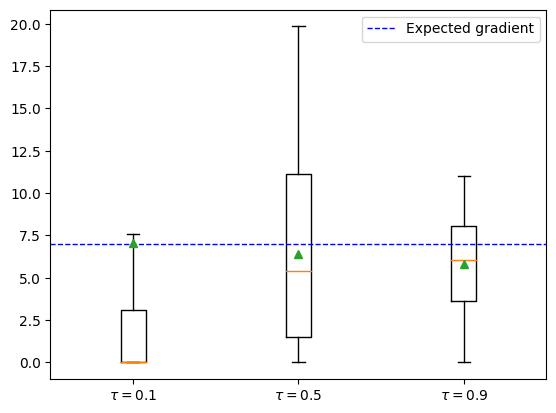

In [13]:
fig, ax = plt.subplots()
for i, (tau, gradients) in enumerate(gradients_per_tau.items()):
    ax.boxplot(gradients, showmeans=True, positions=[i], labels=[f"$\\tau={tau}$"], showfliers=False)
ax.axhline(7, color="blue", linestyle="dashed", linewidth=1, label="Expected gradient")
ax.legend()

The mean and median of each gradient distribution is denoted by a green triangle and orange line respectively. As we would expect, using a low temperature, such as $\tau=0.1$, leads to very low bias. However, we also see that the median is far away from the mean, indiciating that the estimator is also very erratic. In contrast, by using a higher temperature, such as $\tau = 0.9$, we obtain a low varaince estimator, where the mean and median are closer together. Unfortunately, this estimator also has very bias. Using an intermediary temperature, such as $\tau = 0.5$, allows us to strike a trade-off between the behaviours of the aforementioned estimators.

The Gumbel-Softmax trick is an example of a **surrogate gradient**. The funadmental idea behind surrogate gradients is as follows. Consider an operation $g$ which is not differentiable. When applying chain rule, we can replace $g$ with a differentiable $\tilde{g}$ and use its gradient instead. The original surrogate gradient was the straight-through gradient estimator, which simply replaces $g$ with the identity. That is, the gradient pass *straight through* and is left unaltered by the non-differentiable operation $g$. This works surprisingly well in many settings. However, one would intuitively expect the overall gradient to contain more useful information if we choose $\tilde{g}$ close to $g$.

In the final notebook, we will encounter another surrogate used to differentiate through the indicator function. More specifically, given the indicator $\mathbb{I}_{x \geq a}$ we use the following surrogate:

$$
g(x)  = \frac{1}{1+e^{-k(x - a)}}
$$

This is a essentially a Sigmoid function centered at the boundary point $a$. Note that we include the free paramter $k$ which allows us to adapt the steepness of the Sigmoid curve. Increasing $k$ ensures that $g$ is closer to the original indicator function but also increases the risk of observing exploding and vanishing gradients. Thus, similarly to the temperature in the GS trick, selecitng $k$ involves making an inherent trade-off.

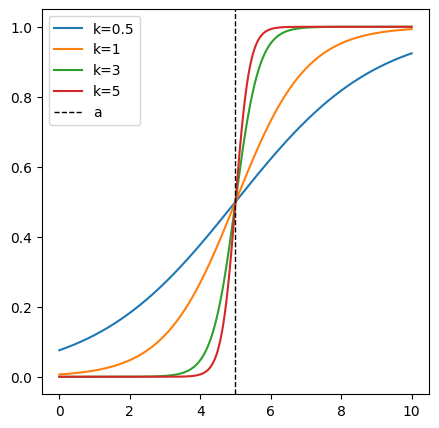

In [20]:
def surrogate(x, a, k):
    return torch.sigmoid( k * (x- a))

n = 1000
xvals = torch.linspace(0., 10, n)
a = torch.tensor(5.)

k1 = surrogate(xvals, a, 0.5)
k2 = surrogate(xvals, a, 1.)
k3 = surrogate(xvals, a, 3.)
k4 = surrogate(xvals, a, 5.)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xvals, k1, label='k=0.5')
ax.plot(xvals, k2, label='k=1')
ax.plot(xvals, k3, label='k=3')
ax.plot(xvals, k4, label='k=5')

ax.axvline(
    a,
    color="black",
    linestyle="dashed",
    linewidth=1,
    label="a",
)

ax.legend()


## Other Resources

To finish, we would like to highlight some relevant literature that is worth checking out if you want to learn more about applying AD in stochastic or discrete settings. 

- The book ["The Elements of Differentiable Programming"](https://arxiv.org/abs/2403.14606) is a fantastic resource detailing how a wide range of operations can be made differentiable. For instance, the book covers differentiable dictionaries and their connection to attention, as well as how to differentiate through optimisation problems.
- The book ["Discrete Latent Structure in Neural Networks"](https://arxiv.org/abs/2301.07473) has a similar flavour. In particular, the book throroughly covers surrogate gradients and smooth relaxations of the $\arg\max$ operator.
- The paper ["Monte Carlo Gradient Estimation in Machine Learning"](https://arxiv.org/abs/1906.10652) is a seminal paper that provides a broad overview of Monte Carlo gradient estimation, especially for settings with continuous densities.
- The papers "[A\* star sampling](https://arxiv.org/abs/1411.0030)" (by Maddison, Tarlow and Minka) and ["Categorical Reparameterisation with Gumbel-Softmax"](https://arxiv.org/abs/1611.01144) (by Jang, Gu and Poole) are fantastic resources to learn more about the GS trick.
- The technical report ["Stochastic Gradient Estimation"](https://apps.dtic.mil/sti/tr/pdf/ADA438511.pdf) (by Michael Fu) provides a computational perspective on differentiation from the viewpoint of discrete event systems. In particular, the report covers FD in great detail. The report also covers smoothed perturbation analysis (SPA), which combines the theory of sample derivatives with conditonal expectations to derive gradient estimators.
- The paper ["Automatic Differentiation with Discrete Randomness"](https://arxiv.org/abs/2210.08572) (by Arya, Schauer, Rakauckas) covers the theory behind StochasticAD.jl, which effectively combines ideas from SPA and AD to differentiate through discrete distributions. The authors have also written some [lecture notes](https://ocw.mit.edu/courses/18-s096-matrix-calculus-for-machine-learning-and-beyond-january-iap-2023/mit18_s096iap23_lec7.pdf) that may be more palatable to first time readers.

Be sure to check out the next notebook, where we will apply what we have learned so far to build a differentiable ABM!
